<a href="https://colab.research.google.com/github/AABrom/Kaggle_nn1/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install razdel pymorphy3

In [3]:
# --- Системные и общие ---
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# --- SKlearn ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# --- NLP-инструменты ---
import nltk
from nltk.corpus import stopwords
from razdel import tokenize as razdel_tokenize
import pymorphy3
from wordcloud import WordCloud

# --- PyTorch & Transformers ---
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import Dataset as HFDataset

# --- Визуализация ---
from graphviz import Digraph

# --- Константы и настройка среды ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Определяем устройство
if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(RANDOM_STATE)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(RANDOM_STATE)
else:
    device = torch.device("cpu")

print(f"✅ Используемое устройство: {device}")

# --- Инициализация лидерборда ---
leaderboard = pd.DataFrame(columns=['Метод', 'R2_Score'])

✅ Используемое устройство: cuda
✅ Используемое устройство: cuda


In [4]:
full_train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Разбиваем исходный train на обучающую и валидационную выборки
train_df, val_df = train_test_split(
    full_train_df,
    test_size=0.25,
    random_state=RANDOM_STATE
)

# Сбрасываем индексы для удобства
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Создаем единое текстовое поле для анализа
text_cols = ['title', 'location', 'company', 'skills', 'description']
for df in [train_df, val_df, test_df]:
    # Заполняем пропуски пустыми строками, чтобы избежать ошибок
    df[text_cols] = df[text_cols].fillna('')
    # Объединяем текстовые колонки через разделитель
    df['full_text'] = df[text_cols].agg(' | '.join, axis=1)

print("Пример данных из train:")
display(train_df[['full_text', 'log_salary_from']].head(3))

FileNotFoundError: [Errno 2] No such file or directory: './train.csv'

In [ ]:
# Загружаем стоп-слова
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('russian'))
# Добавим специфичные для вакансий стоп-слова
stop_words.update(['наш', 'компания', 'команда', 'работа', 'вакансия', 'искать'])

# Инициализируем лемматизатор pymorphy3
morph = pymorphy3.MorphAnalyzer()

def preprocess_text(text: str) -> str:
    """Полный цикл предобработки текста с использованием pymorphy3."""
    # 1. Токенизация
    tokens = [token.text for token in razdel_tokenize(text)]
    # 2. Приведение к нижнему регистру и удаление не-буквенных токенов
    lower_tokens = [token.lower() for token in tokens if token.isalpha()]
    # 3. Лемматизация и удаление стоп-слов
    lemmas = [morph.parse(token)[0].normal_form for token in lower_tokens]
    cleaned_lemmas = [lemma for lemma in lemmas if lemma not in stop_words]
    return " ".join(cleaned_lemmas)

# Демонстрируем работу на одном примере
sample_text = train_df['full_text'].iloc[0]
print(f"ИСХОДНЫЙ ТЕКСТ: '{sample_text[:200]}...'")
print(f"ОБРАБОТАННЫЙ ТЕКСТ: '{preprocess_text(sample_text)}'")

# Применяем ко всем данным
tqdm.pandas(desc="Preprocessing Train")
train_df['processed_text'] = train_df['full_text'].progress_apply(preprocess_text)
tqdm.pandas(desc="Preprocessing Val")
val_df['processed_text'] = val_df['full_text'].progress_apply(preprocess_text)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#создаем словарь
def build_vocab(texts, min_freq=10):
    counter = Counter()
    for text in texts:
        counter.update(text.split())
    vocab = {'<pad>':0, '<unk>':1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def text2indices(text, word2ind):
    return [word2ind.get(w, word2ind['<unk>']) for w in text.split()]


In [ ]:
def collate_fn_with_padding(batch, pad_idx=0):
  #настройка объединения батчей в DataLoader
    texts, targets = zip(*batch)
    lengths = [len(t) for t in texts]
    max_len = max(lengths)

    padded_texts = []
    for t in texts:
        padded = t + [pad_idx] * (max_len - len(t))
        padded_texts.append(padded)
    padded_texts = torch.tensor(padded_texts, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.float)
    return padded_texts, targets

In [ ]:
class SalaryDataset(Dataset):
    def __init__(self, texts, targets, word2ind):
        self.texts = [text2indices(t, word2ind) for t in texts]
        self.targets = targets

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.targets[idx]

In [ ]:
vocab = build_vocab(train_df['processed_text'].tolist())

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 8529


In [ ]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, device, vocab):
    # Критерий для регрессии - MSELoss, R2-score отслеживаем только на валидации
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    val_losses = []
    val_r2_scores = []

    for epoch in range(num_epochs):

        model.train()
        epoch_train_losses = []

        for x_batch, y_batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}/{num_epochs}'):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad() # обнуляем градиенты
            preds = model(x_batch) # прямой проход
            loss = criterion(preds, y_batch) # лоссы

            loss.backward() # backward подсчет градиентов
            optimizer.step() # обновляем веса

            epoch_train_losses.append(loss.item())

        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)


        model.eval()
        epoch_val_losses = []
        all_val_preds = []
        all_val_targets = []

        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_dataloader, desc=f'Validation epoch {epoch+1}/{num_epochs}'):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                preds = model(x_batch)
                loss = criterion(preds, y_batch)

                epoch_val_losses.append(loss.item())

                # предсказания и истинные значения для R2
                all_val_preds.extend(preds.cpu().numpy())
                all_val_targets.extend(y_batch.cpu().numpy())

        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        val_losses.append(avg_val_loss)

        # R2- на всей валидационной выборке
        val_r2 = r2_score(all_val_targets, all_val_preds)
        val_r2_scores.append(val_r2)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss = {avg_train_loss:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, "
              f"Val R2-score = {val_r2:.4f}")

    return train_losses, val_losses, val_r2_scores

In [ ]:
class SimpleRegressionModel(nn.Module):
  #простая модель регрессии, бейслайн
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, pad_idx=0):
        super(SimpleRegressionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)
        emb = emb * mask
        summed = emb.sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-9)
        avg_emb = summed / counts
        h = self.relu(self.fc1(avg_emb))
        out = self.fc2(h).squeeze(1)
        return out

In [ ]:
train_dataset = SalaryDataset(train_df['processed_text'].tolist(), train_df['log_salary_from'].tolist(), vocab)
val_dataset = SalaryDataset(val_df['processed_text'].tolist(), val_df['log_salary_from'].tolist(), vocab)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          collate_fn=lambda batch: collate_fn_with_padding(batch, pad_idx=vocab['<pad>']))

#на валидации не перемешиваем
val_loader = DataLoader(val_dataset, batch_size=32,
                        collate_fn=lambda batch: collate_fn_with_padding(batch, pad_idx=vocab['<pad>']))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleRegressionModel(len(vocab), pad_idx=vocab['<pad>']).to(device)

num_epochs = 10
train_losses, val_losses, val_r2_scores = train_model(
    model, train_loader, val_loader, num_epochs, device, vocab
)
print("\nTraining completed!")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Val R2-score: {val_r2_scores[-1]:.4f}")

Training epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 1/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/10: Train Loss = 2.3179, Val Loss = 0.3154, Val R2-score = 0.1941


Training epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 2/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/10: Train Loss = 0.2613, Val Loss = 0.2320, Val R2-score = 0.4071


Training epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 3/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/10: Train Loss = 0.1945, Val Loss = 0.2001, Val R2-score = 0.4883


Training epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 4/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/10: Train Loss = 0.1621, Val Loss = 0.1809, Val R2-score = 0.5379


Training epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 5/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/10: Train Loss = 0.1412, Val Loss = 0.1713, Val R2-score = 0.5625


Training epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 6/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/10: Train Loss = 0.1267, Val Loss = 0.1654, Val R2-score = 0.5776


Training epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 7/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/10: Train Loss = 0.1151, Val Loss = 0.1681, Val R2-score = 0.5716


Training epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 8/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/10: Train Loss = 0.1072, Val Loss = 0.1602, Val R2-score = 0.5911


Training epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 9/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/10: Train Loss = 0.0984, Val Loss = 0.1630, Val R2-score = 0.5833


Training epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 10/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10/10: Train Loss = 0.0915, Val Loss = 0.1650, Val R2-score = 0.5788

Training completed!
Final Train Loss: 0.0915
Final Val Loss: 0.1650
Final Val R2-score: 0.5788


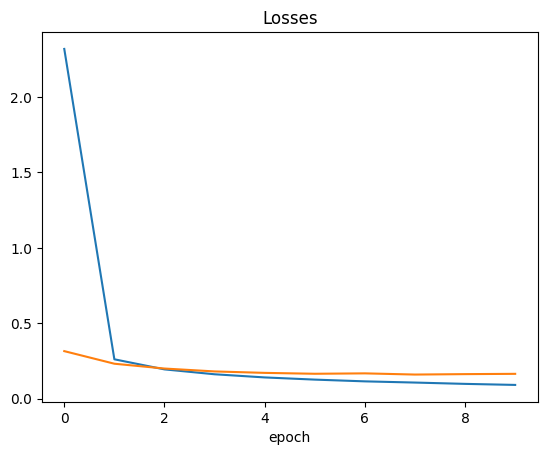

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

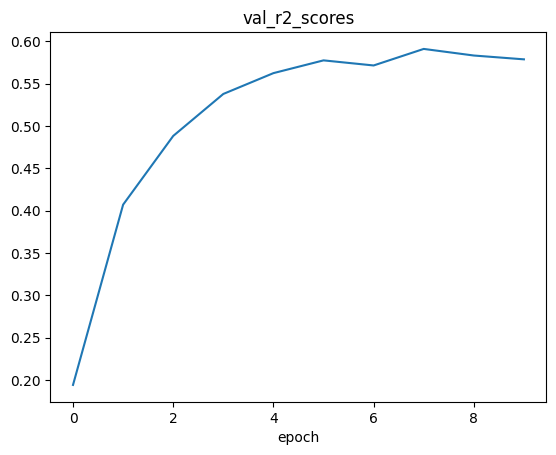

In [ ]:
plt.plot(np.arange(len(val_r2_scores)), val_r2_scores)
plt.title('val_r2_scores')
plt.xlabel("epoch")
plt.show()

In [ ]:
test_df['processed_text'] = test_df['full_text'].progress_apply(preprocess_text)

# dataset для теста
class TestSalaryDataset(Dataset):
    def __init__(self, texts, word2ind):
        self.texts = texts
        self.vocab = word2ind
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        tokens = self.texts[idx].split()
        indices = [self.vocab.get(t, self.vocab['<unk>']) for t in tokens]
        return indices

test_dataset = TestSalaryDataset(test_df['processed_text'].tolist(), vocab)

test_loader = DataLoader(test_dataset, batch_size=32,
                         collate_fn=lambda batch: collate_fn_with_padding([(x, 0) for x in batch], pad_idx=vocab['<pad>']))


model.eval()
predictions = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch)
        predictions.extend(preds.cpu().numpy())

Preprocessing Val:   0%|          | 0/5556 [00:00<?, ?it/s]

In [ ]:
submition = pd.read_csv('sample_submition.csv')
submition.prediction = predictions

In [ ]:
submition.to_csv('linear_sub.csv', index = False)

In [ ]:
class GRURegressionModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim: int, num_layers: int, dropout_rate: float, pad_idx: int):
      #
        super().__init__()
        # Сохраняем для инициализации скрытого состояния:
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        #дополнительный линейный слой и тангенциальная активация
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.output_projection = nn.Linear(hidden_dim, 1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, hidden = self.gru(embeddings)

        final_hidden_state = hidden[-1, :, :]  # последнее скрытое состояние

        processed_hidden = self.dropout(self.linear(self.non_lin(final_hidden_state)))

        prediction = self.output_projection(self.non_lin(processed_hidden)).squeeze(1)  # Регрессия

        return prediction


Эксперимент с регрессионной моделью на GRU приводит к нестабильному результату:

In [ ]:
model = GRURegressionModel(len(vocab), hidden_dim=256, num_layers=4, dropout_rate=0.2, pad_idx=vocab['<pad>']).to(device)

train_losses, val_losses, val_r2_scores = train_model(model, train_loader, val_loader, num_epochs=30, device=device, vocab=vocab)

print("\nTraining completed!")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Val R2-score: {val_r2_scores[-1]:.4f}")

Training epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 1/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/30: Train Loss = 0.6324, Val Loss = 0.4614, Val R2-score = -0.1803


Training epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 2/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/30: Train Loss = 0.2923, Val Loss = 0.8541, Val R2-score = -1.1826


Training epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 3/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/30: Train Loss = 0.2446, Val Loss = 0.7141, Val R2-score = -0.8256


Training epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 4/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/30: Train Loss = 0.1999, Val Loss = 0.3912, Val R2-score = -0.0007


Training epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 5/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/30: Train Loss = 0.1728, Val Loss = 0.9152, Val R2-score = -1.3382


Training epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 6/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/30: Train Loss = 0.1529, Val Loss = 1.1557, Val R2-score = -1.9510


Training epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

Validation epoch 7/30:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/30: Train Loss = 0.1378, Val Loss = 0.8419, Val R2-score = -1.1510


Training epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

In [ ]:
plt.plot(np.arange(len(val_r2_scores)), val_r2_scores)
plt.title('val_r2_scores')
plt.xlabel("epoch")
plt.show()

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch)
        predictions.extend(preds.cpu().numpy())

In [ ]:
submition.prediction = predictions
submition.to_csv('GRU_sub.csv', index = False)

In [ ]:
class BertRegressionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.targets[idx], dtype=torch.float)
        return item


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=1  # регрессия
).to(device)

In [ ]:
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import r2_score

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)  # [batch, 1]

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits
        loss_fct = nn.MSELoss()
        loss = loss_fct(preds, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return sum(losses)/len(losses)

def eval_epoch(model, data_loader, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    loss_fct = nn.MSELoss()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits
            loss = loss_fct(preds, labels)
            losses.append(loss.item())
            all_preds.extend(preds.cpu().squeeze(1).tolist())
            all_labels.extend(labels.cpu().squeeze(1).tolist())
    avg_loss = sum(losses)/len(losses)
    r2 = r2_score(all_labels, all_preds)
    return avg_loss, r2


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 4
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_r2 = eval_epoch(model, val_loader, device)
    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val R2 {val_r2:.4f}')

test_dataset = BertRegressionDataset(test_df['processed_text'].tolist(), [0]*len(test_df), tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1).cpu().tolist()
        predictions.extend(preds)
